In [1]:
import xarray as xr
import math 
import numpy as np 
import matplotlib.pyplot as plt 
import s3fs

In [2]:
# open the data with s3fs from the databucket 
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
data_path2 = 's3://velocity-u.zarr'
data_path3 = 's3://velocity-v.zarr'

remote_files2 = fsg.glob(data_path2)
remote_files3 = fsg.glob(data_path3)

store2 = s3fs.S3Map(root=data_path2, s3=fsg, check=False)
store3 = s3fs.S3Map(root=data_path3, s3=fsg, check=False)

du = xr.open_zarr(store=store2, consolidated=True)
dv = xr.open_zarr(store=store3, consolidated=True)

In [10]:
u = du.vozocrtx.isel(x=slice(200,1400),y=slice(650,1800)).rename({'depthu' : 'depth'})
v = dv.vomecrty.isel(x=slice(200,1400),y=slice(650,1800)).rename({'depthv' : 'depth'})

In [14]:
x = 836
y = 440
d = 15
rd = xr.merge([u.isel(x=x,y=y,depth=d),v.isel(x=x,y=y,depth=d)], compat='override')

In [39]:
up = np.array(rd.vozocrtx.values)
vp = np.array(rd.vomecrty.values)

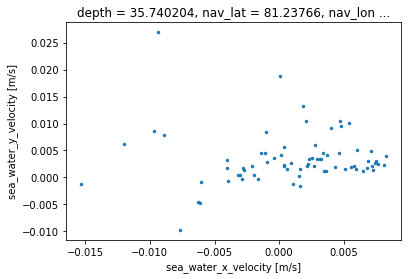

In [15]:
rd.plot.scatter(x='vozocrtx', y='vomecrty', s=6)

In [17]:
vec = np.array([2,4])
print(vec[0],vec[1])

velp = (u.isel(x=x,y=y,depth=d)*vec[0] + v.isel(x=x,y=y,depth=d)*vec[1])/np.sqrt(vec[0]**2+vec[1]**2)
velo = (- u.isel(x=x,y=y,depth=d)*vec[1] + v.isel(x=x,y=y,depth=d)*vec[0])/np.sqrt(vec[0]**2+vec[1]**2) #rotere vector [x,y] 90 grader m/klokka = [x,-y]

vel_r = xr.merge([velp.to_dataset(name='vpar'),velo.to_dataset(name='vort')],compat='override')

2 4


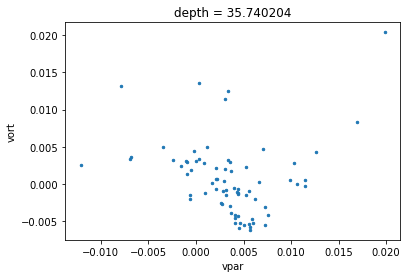

In [18]:
vel_r.plot.scatter(x='vpar', y='vort', s=6)

In [35]:
v_r = np.array(vel_r.vpar.values)
v_o = np.array(vel_r.vort.values)

Før rotasjon


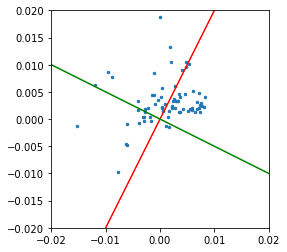

In [45]:
print('Før rotasjon')
fig, ax = plt.subplots()
ax.scatter(up,vp,s=6)
ax.plot([0,vec[0]],[0,vec[1]],'r')
ax.plot([0,-vec[0]],[0,-vec[1]],'r')
ax.plot([0,-vec[1]],[0,vec[0]],'g')
ax.plot([0,vec[1]],[0,-vec[0]],'g')
ax.set_xlim(-0.02,0.02)
ax.set_ylim(-0.02,0.02)
ax.set_aspect('equal')

etter rotasjon


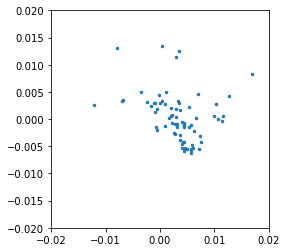

In [47]:
print('etter rotasjon')
fig, ax = plt.subplots()
ax.scatter(v_r,v_o,s=6)
#ax.plot([0,vec[0]],[0,vec[1]],'r')
#ax.plot([0,-vec[0]],[0,-vec[1]],'r')
#ax.plot([0,-vec[1]],[0,vec[0]],'g')
#ax.plot([0,vec[1]],[0,-vec[0]],'g')
ax.set_xlim(-0.02,0.02)
ax.set_ylim(-0.02,0.02)
ax.set_aspect('equal')

In [38]:
#a = np.array([2,4])
#b = np.array([-4,2])
a = np.array([vec[0],vec[1]])
b = np.array([-vec[1],vec[0]])
print(a,b)
d = np.dot(a,b)
print(d) # d=0 --> disse skal være orthogonale 

[2 4] [-4  2]
0


In [40]:
# teste amplitude : 
af = up**2 + vp**2
ae = v_r**2 + v_o**2
print(af)
print(ae)

[2.64694590e-05 2.14877946e-05 3.27288762e-05 2.37115614e-06
 4.96440862e-06 1.10666406e-05 2.20875827e-05 2.67649011e-06
 1.91894160e-05 8.68615098e-06 4.78879019e-06 1.28146075e-05
 1.83062701e-04 1.40151387e-04 8.11618869e-04 1.78741917e-04
 1.67830556e-04 6.00671265e-05 1.61642929e-05 9.43140640e-06
 2.35202504e-04 1.02902222e-05 5.96863501e-05 9.04055469e-06
 3.69056397e-05 3.85258591e-06 1.53724584e-04 2.78896164e-06
 8.78689843e-06 8.53496203e-06 1.68726692e-05 8.41556539e-06
 4.58894738e-06 5.22865867e-06 1.08946606e-05 2.13231506e-05
 2.00020077e-05 2.15845794e-05 1.66129830e-05 1.95472512e-05
 8.84337533e-06 1.17892832e-05 2.71976819e-06 1.45248168e-05
 1.34432339e-05 2.85294809e-05 3.45969056e-05 2.19531921e-05
 3.78227487e-05 5.56442865e-05 5.66802701e-05 3.78463374e-05
 4.39854412e-05 7.05886632e-05 4.94814594e-05 6.49812719e-05
 5.49507604e-05 6.45378896e-05 6.14972523e-05 8.36558611e-05
 7.44062927e-05 6.25987814e-05 3.02414719e-05 4.25025864e-05
 3.24623979e-05 9.882492

In [48]:
def open_s3fs(path):
    # open the data with s3fs from the databucket 
    fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://karen.uiogeo-apps.sigma2.no'
      })
    data_path = f's3://data/{path}'
    remote_files = fsg.glob(data_path)
    fileset = [fsg.open(file) for file in remote_files]
    #open the dataset 
    dset = xr.open_mfdataset(fileset, 
                             #combine='by_coords',
                             compat='override')
    return dset

In [49]:
d15 = open_s3fs('mooring_barents/A-TWAIN_2015-2017_AT200-3_22-118m_ACDP_16640.nc')

In [50]:
u15 = d15.UCUR.fillna(0).squeeze(axis=0)
v15 = d15.VCUR.fillna(0).squeeze(axis=0)

In [52]:
u15

<xarray.DataArray 'UCUR' (TIME: 52442, nDEPTH: 12)>
dask.array<getitem, shape=(52442, 12), dtype=float64, chunksize=(52442, 12), chunktype=numpy.ndarray>
Coordinates:
    STATION    int32 1
    DEPTH      (TIME, nDEPTH) float64 dask.array<chunksize=(52442, 12), meta=np.ndarray>
  * TIME       (TIME) datetime64[ns] 2015-09-19T21:59:59.999996928 ... 2017-0...
    LATITUDE   float64 dask.array<chunksize=(), meta=np.ndarray>
    LONGITUDE  float64 dask.array<chunksize=(), meta=np.ndarray>
Dimensions without coordinates: nDEPTH
Attributes: (12/13)
    ancillary_variables:    PLATFORM INSTRUMENT CRS
    cell_methods:           DEPTH: point LATITUDE: point LONGITUDE: point TIM...
    coverage_content_type:  physicalMeasurement
    grid_mapping:           CRS
    instrument:             INSTRUMENT
    long_name:              eastward current velocity
    ...                     ...
    processing_level:       Known bad data has been replaced with null values
    source:                 mooring
    standard_name:          eastward_sea_water_velocity
    units:                  cm/s
    valid_max:              [64.67812772]
    valid_min:              [-51.96318957]

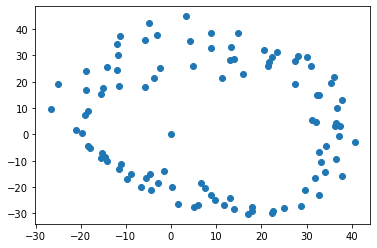

In [58]:
fig, ax = plt.subplots()
ax.scatter(u15.isel(TIME= slice(1000,1100),nDEPTH=5),v15.isel(TIME= slice(1000,1100),nDEPTH=5))

In [61]:
v_p = (u15.isel(TIME= slice(1000,1100),nDEPTH=5)*vec[0] + v15.isel(TIME= slice(1000,1100),nDEPTH=5)*vec[1])/np.sqrt(vec[0]**2+vec[1]**2)
v_o = (- u15.isel(TIME= slice(1000,1100),nDEPTH=5)*vec[1] + v15.isel(TIME= slice(1000,1100),nDEPTH=5)*vec[0])/np.sqrt(vec[0]**2+vec[1]**2) 

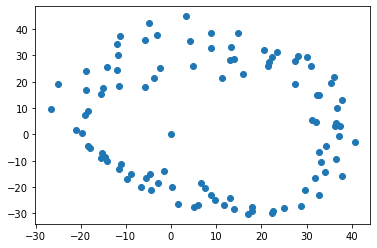

In [62]:
fig, ax = plt.subplots()
ax.scatter(v_p,v.isel(TIME= slice(1000,1100),nDEPTH=5))